Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Tuesday, October 24, 2017.

In [1]:
%matplotlib inline
import numpy as np
#import pymc as pm
import pylab as plt
import pandas as pd

# Set seed
np.random.seed(10011)

# Question 1

Epidemiologists are interested in studying the sexual behavior of individuals at risk for HIV infection. Suppose 1500 gay men were surveyed and each was asked how many risky sexual encounters he had in the previous 30 days. Let $n_i$ denote the number of respondents reporting $i$ encounters, for $i = 1, \ldots , 16$. The DataFrame below contains these reponses:

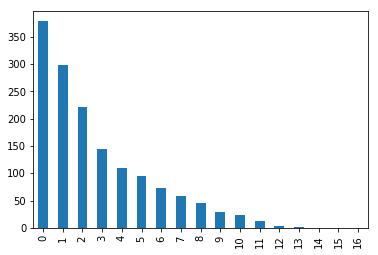

In [2]:
encounters = pd.DataFrame({'count': np.arange(17),
                          'freq': [379, 299, 222, 145, 109, 95, 73, 59,
                                  45, 30, 24, 12, 4, 2, 0, 1, 1]})

encounters.freq.plot.bar()

These data are poorly fitted by a Poisson model. It is more realistic to assume that the respondents comprise three groups. First, there is a group of people who, for whatever reason, report zero risky encounters even if this is not true. Suppose a respondent has probability $\alpha$ of belonging to this group. 

With probability $\beta$, a respondent belongs to a second group representing typical behavior. Such people respond truthfully, and their numbers of risky encounters are assumed to follow a $\text{Poisson}(\mu)$ distribution. 

Finally, with probability $1 − \alpha − \beta$, a respondent belongs to a high-risk group. Such people respond truthfully, and their numbers of risky encounters are assumed to follow a $\text{Poisson}(\lambda)$ distribution. 

The parameters in the model are $\alpha, \beta, \mu$ and $\lambda$. At the tth iteration of EM, we use $\theta^{(t)} = (\alpha^{(t)}, \beta^{(t)}, \mu^{(t)}, \lambda^{(t)})$ to denote the current parameter values. The likelihood of the observed data is given by:

$$L(\theta | n_0, \ldots, n_16) \propto \prod_{i=0}^{16} \left[ \frac{\pi_i(\theta)}{i!} \right]^{n_i}$$

where $\pi_i(\theta) = \alpha 1_{(i=0)} + \beta \mu^i \exp(-\mu) + (1-\alpha - \beta) \lambda^i \exp(-\lambda)$.

The observed data are in the `encounters` table above; the *complete* data may be construed to be $(n_{z,0}, n_{t,0}, n_{p,0}), \ldots, (n_{z,16}, n_{t,16}, n_{p,16})$, where $k = z, t, p$ correspond to zero, typical and promiscuous groups, respectively. That is, $n_0 = n_{z,0} + n_{t,0} + n_{p,0}$, and so on. Let $N = \sum_{i=0}^{16} n_i = 1500$.

Also define:

$$\begin{align}
z_0(\theta) &=& \frac{\alpha}{\pi_0(\theta)} \\
t_i(\theta) &=& \frac{\beta \mu^i \exp(-\mu)}{\pi_i(\theta)} \\
p_i(\theta) &=& \frac{(1-\alpha-\beta)\lambda^i \exp(-\lambda)}{\pi_i(\theta)}
\end{align}$$

which correspond to probabilities that respondents with $i$ risky encounters belong to various groups.

a. Show that the EM algorithm provides the following updates:

$$\begin{align}
\alpha^{(t+1)} &=& \frac{n_0 z_0(\theta^{(t)})}{N} \\
\beta^{(t+1)} &=& \sum_i \frac{n_i t_i(\theta^{(t)})}{N} \\
\mu^{(t+1)} &=& \frac{\sum_i i n_i t_i(\theta^{(t)})}{\sum_i n_i t_i(\theta^{(t)})} \\
\lambda^{(t+1)} &=& \frac{\sum_i i n_i p_i(\theta^{(t)})}{\sum_i n_i p_i(\theta^{(t)})}
\end{align}$$


b. Extimate the parameters of the model using the observed data.

In [3]:
# Write your answer here

In [9]:
from scipy.stats.distributions import poisson


def e_step(alpha,beta,mu,lam):
    t=[]
    p=[]
    
    for i in range(0,16+1):
        pi=alpha*(i==0)+beta*np.exp(-mu)*(mu**i) +(1-alpha-beta)*(lam**i)*np.exp(-lam)
        z= alpha/pi*(i==0)
        ti=beta*(mu**i)*np.exp(-mu)/pi
        t.append(ti)
        
        pt=(1-alpha-beta)*(lam**i)*np.exp(-lam)/pi
        p.append(pt)
    
    return z,t,p

def m_step(z,t,p,n,N=1500):
    #n is a vector of n0,n1,...,n16
    # w is the combination of z,t,p from e step
    
    
    t=np.array(t)
    p=np.array(p)
    
    alpha= n[0]*z/N
    beta=np.sum(n*t/N)
    
    tsum=0
    for i in range(0,16+1):
        tsum=tsum+i*n[i]*t[i]
        
    mu=tsum/np.sum(n*t)
    
    psum=0
    for i in range(0,16+1):
        psum=psum+i*p[i]*n[i]
    
    lam=psum/np.sum(n*t)
    
    return alpha,beta,mu,lam


resp=np.array([379, 299, 222, 145, 109, 95, 73, 59,45, 30, 24, 12, 4, 2, 0, 1, 1]) #data
    

def run_em(alpha0=0.2, beta0=0.2,mu0=5,lam0=5, n=resp):
    
    # Initialize values
    alpha=alpha0
    beta=beta0
    mu=mu0
    lam=lam0

    # Stopping criterion
    crit = 1e-5

    # Convergence flag
    converged = False

    # Loop until converged
    while not converged:

        # E-step
        z,t,p = e_step(alpha,beta,mu,lam)
        # M-step
        alpha_new, beta_new,mu_new,lam_new = m_step(z,t,p,n)

        # Check convergence
        converged = ( np.all(np.abs((np.array(alpha_new) - np.array(alpha)) < crit)) 
                     & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                     & np.all(np.abs((np.array(beta_new) - np.array(beta)) < crit))
                     & np.all(np.abs((np.array(lam_new) - np.array(lam)) < crit)) ) 
                
        alpha, beta, mu, lam = alpha_new, beta_new,mu_new,lam_new

    return  alpha, beta, mu, lam

run_em(alpha0=0.6)

(0.0, 0.52483006652390773, 0.77505041207014569, 4.365661166955018)

In [26]:
a,b,c=e_step(1,2,3,4)

In [15]:
a

-0.0

In [18]:
len(b)

17

In [27]:
n=np.array([379, 299, 222, 145, 109, 95, 73, 59,45, 30, 24, 12, 4, 2, 0, 1, 1])

In [22]:
type(n)

list

In [28]:
b=np.array(b)

In [ ]:
print(np.sum(n*b))

In [4]:
def m_step(z,t,p,n,N=1500):
    #n is a vector of n0,n1,...,n16
    # w is the combination of z,t,p from e step
    
    
    t=np.array(t)
    p=np.array(p)
    
    alpha= n[0]*z/N
    beta=np.sum(n*t/N)
    
    tsum=0
    for i in range(0,16+1):
        tsum=tsum+i*n[i]*t[i]
        
    mu=tsum/np.sum(n*t)
    
    psum=0
    for i in range(0,16+1):
        psum=psum+i*p[i]*n[i]
    
    lam=psum/np.sum(n*t)
    
    return alpha,beta,mu,lam


In [35]:
m_step(a,b,c)

(-0.0, 0.94747634992871843, 0.56861375574705153, 2.2789507245726726)

In [8]:
resp=np.array([379, 299, 222, 145, 109, 95, 73, 59,45, 30, 24, 12, 4, 2, 0, 1, 1]) #data
    

def run_em(alpha0=0.2, beta0=0.5,mu0=5,lam0=5, n=resp):
    
    # Initialize values
    alpha=alpha0
    beta=beta0
    mu=mu0
    lam=lam0

    # Stopping criterion
    crit = 1e-5

    # Convergence flag
    converged = False

    # Loop until converged
    while not converged:

        # E-step
        z,t,p = e_step(alpha,beta,mu,lam)
        # M-step
        alpha_new, beta_new,mu_new,lam_new = m_step(z,t,p,n)

        # Check convergence
        converged = ( np.all(np.abs((np.array(alpha_new) - np.array(alpha)) < crit)) 
                     & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                     & np.all(np.abs((np.array(beta_new) - np.array(beta)) < crit))
                     & np.all(np.abs((np.array(lam_new) - np.array(lam)) < crit)) ) 
                
        alpha, beta, mu, lam = alpha_new, beta_new,mu_new,lam_new

    return  alpha, beta, mu, lam

In [9]:
run_em(alpha0=0.6)

(0.0, -4.2560460885945739, 0.55559594525599321, -1.189517651891207)

In [7]:
list(range(0,17))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# Question 2

Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta = \log(p/(1 − p))$. Our prior for $\theta$ is that $\theta \sim N(\mu, \sigma^2)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by:

$$\pi(\theta | y) \propto \frac{\exp(y\theta)}{(1 + exp(\theta))^n} \exp\left[\frac{-(\theta − \mu)^2}{2\sigma^2}\right]$$

For example, suppose we are interested in learning about the probability that a possibly-biased coin lands heads when tossed. *A priori* we believe that the coin is fair, so we assign $\theta$ a $N(0,.25)$ prior. We toss the coin $n = 5$ times and obtain $y = 5$ heads.

1. Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that θ is positive).
2. Using the prior density as a proposal density, design a rejection algorithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.
3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

In [10]:
# Write your anser here
#1. normal approximation
import scipy as sp
import scipy.stats as stats

binom=stats.binom
norm=stats.norm

def post_norm(theta,n=5,y=5): #log of post probability
    post=(y*theta)-np.log((1+np.exp(theta))**n) -(theta**2)/(2*0.25)
    return post

from scipy.optimize import minimize

post_min = lambda *args: -post_norm(*args)

#logarithm of the unnormalized joint posterior:approximating the density as normal.

init_value = 0.5 

opt = minimize(post_min, init_value, method='L-BFGS-B')
mode = opt.x
var = opt.hess_inv.todense() 
mode, var # mode and variance to returns the kernel of a normal distribution 


#compute the probability that the coin is biased toward heads (i.e., that θ is positive).
1-norm.cdf(0,loc=mode,scale=np.sqrt(var)) 

array([[ 0.86179511]])

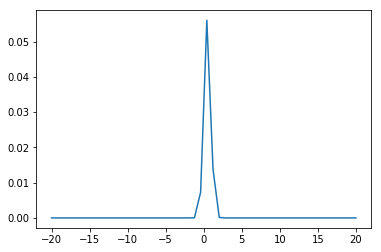

In [46]:
x=np.linspace(-20,20)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(x, np.exp(post_norm(x)))

In [47]:
np.exp(post_norm(-3))

3.6540627729200116e-15

In [7]:
from scipy.optimize import minimize

post_min = lambda *args: -post_norm(*args)

#logarithm of the unnormalized joint posterior:approximating the density as normal.

init_value = 0.5 

opt = minimize(post_min, init_value, method='L-BFGS-B')
mode = opt.x
var = opt.hess_inv.todense() 
mode, var # mode and variance to returns the kernel of a normal distribution 

NameError: name 'np' is not defined

In [65]:
opt

      fun: array([ 2.869167])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.77315973e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 2
   status: 0
  success: True
        x: array([ 0.47831304])

In [50]:
det = np.linalg.det #determinant of array 
inv = np.linalg.inv #inverse of matrix

def lmvn(value, mu, Sigma):#post prob
    delta = value - mu
    return  -0.5 * (np.log(det(Sigma)) + np.dot(delta, np.dot(inv(Sigma), delta)))

In [94]:
norm.pdf(5,loc=mode,scale=np.sqrt(var))

array([[  9.30673722e-24]])

In [79]:
1-norm.cdf(0,loc=mode,scale=np.sqrt(var)) #compute the probability that the coin is biased toward heads (i.e., that θ is positive).

array([[ 0.86179511]])

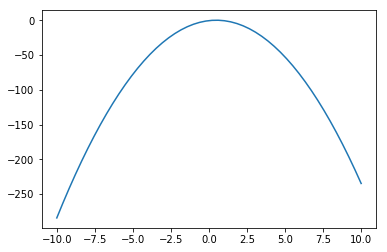

In [60]:
k_x = np.linspace(-10, 10)

z = np.array([lmvn(t1,mode,var) 
               for t1 in k_x ] )

import matplotlib.pyplot as plt #show the plot of h(theta)-h(theta_mle)
fig, ax = plt.subplots(1, 1)
ax.plot(k_x, z-z.max())           

In [95]:

np.exp(lmvn(5,mode,var)-z.max() )


1.0739212252233608e-23

ValueError: x and y must have same first dimension, but have shapes (50,) and (1, 50)

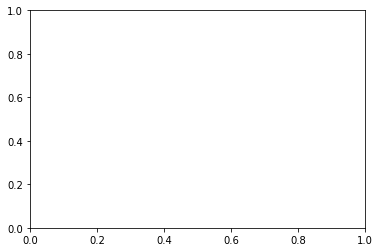

In [64]:
fig, ax = plt.subplots(1, 1)
ax.plot(k_x, norm.cdf(k_x,mode,var))

In [28]:
post_norm(1)

-3.5663084375911138

In [26]:
np.exp(post_norm(mode))

array([ 0.05674618])

In [32]:
lmvn(3,mode,var) 

1.6110119884663382e-07

2.Using the prior density as a proposal density, design a rejection algorithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.

In [ ]:
#sample  g(x),  accept or reject each of these values based upon  f(xi)
#draw a uniform random variate ui
#for each draw  accept  xixi  if  ui<f(xi)/cg(xi), where  c  is a constant


In [93]:
def post_norm(theta,n=5,y=5): #log of post probability
    post=(y*theta)-np.log((1+np.exp(theta))**n) -(theta**2)/(2*0.25)
    return post

def calc_diff(theta):
    
    return post_norm(theta) - norm.logpdf(theta, 0, 0.5)

calc_diff_min = lambda *args: -calc_diff(*args)

c=opt.fun

def reject(n,  c):
    
    # Draw samples from g(theta)
    theta = norm.rvs(0, 0.5, size=n)
    
    # Calculate probability under g(theta)
    gvals = np.array([norm.logpdf(t,0,0.5) for t in theta])

    # Calculate probability under f(theta)
    fvals = np.array([post_norm(t) for t in theta ])
    
    # Calculate acceptance probability
    p = np.exp(fvals - gvals + c)
    
    return theta[np.random.random(n) < p]
    #return p,theta,fvals,gvals
    
nsamples = 15000
sample = reject(nsamples,  c)
sum(sample>0)/(sample.size) #from accepted samples, what proportion >0

In [89]:
np.exp(post_norm(0)-norm.logpdf(0,0,0.5)-0.22)

0.031431504842119234

In [84]:
post_norm(0)

-3.4657359027997265

In [94]:
from scipy.optimize import minimize
opt = minimize(calc_diff_min, 
               -3, 
                method='bfgs')

In [83]:
calc_diff(-4)

-19.864958286944322

In [95]:
opt

      fun: -0.22578268286588354
 hess_inv: array([[ 36795.80102572]])
      jac: array([ -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 17
     njev: 19
   status: 0
  success: True
        x: array([ 13.26510432])

In [96]:
c=opt.fun

In [97]:
def reject(n,  c):
    
    # Draw samples from g(theta)
    theta = norm.rvs(0, 0.5, size=n)
    
    # Calculate probability under g(theta)
    gvals = np.array([norm.logpdf(t,0,0.5) for t in theta])

    # Calculate probability under f(theta)
    fvals = np.array([post_norm(t) for t in theta ])
    
    # Calculate acceptance probability
    p = np.exp(fvals - gvals + c)
    
    return theta[np.random.random(n) < p]
    #return p,theta,fvals,gvals

In [103]:
nsamples = 15000
sample = reject(nsamples,  c)
sum(sample>0)/(sample.size) #from accepted samples, what proportion >0


0.85350318471337583

In [101]:
sum(sample>0)/(sample.size)

0.86293436293436299

In [67]:
p,theta,fv,gv=sample

In [59]:
gv.shape

(1000,)

In [72]:
theta

array([ -5.91022886e-01,  -3.35050609e-01,   4.73844434e-01,
        -7.92442197e-02,  -9.04182700e-02,   3.85583336e-01,
         5.66141272e-01,  -1.02955662e+00,  -3.32755165e-02,
        -1.29042917e-01,  -2.51582133e-01,  -1.53568589e-01,
         2.26296353e-01,   6.41343374e-01,   2.49823977e-01,
        -1.19222597e-01,   6.32323198e-01,  -5.61262634e-01,
         1.68971538e-01,  -5.15850280e-01,  -3.91709995e-01,
         1.80249423e-01,  -5.68079468e-01,  -5.55295715e-01,
         9.16318941e-01,  -2.31171667e-02,   6.82266392e-01,
         6.78293624e-01,  -1.60546829e-01,   5.25949116e-01,
         2.69163344e-01,  -5.78780141e-03,  -6.35933908e-01,
        -5.26003211e-02,  -6.60201294e-01,  -2.04963119e-01,
        -2.44053567e-01,   1.49885016e-01,  -1.83038868e-01,
         5.95927487e-01,   5.82048797e-01,   5.07317567e-01,
        -9.85142407e-02,   9.19148609e-02,  -1.07490744e+00,
         5.03850441e-02,   2.39862790e-01,   3.51491059e-01,
         1.42502437e-02,

In [61]:
fv.shape

(1000,)

3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

In [115]:
n=20000
theta = norm.rvs(0, 0.5, size=n)
    
# Calculate probability under q(theta)-prior
q_theta = np.array([norm.logpdf(t,0,0.5) for t in theta])

# Calculate probability under f(theta)-posterior
f_theta = np.array([post_norm(t) for t in theta ])
    
w = np.exp(f_theta - q_theta - max(f_theta - q_theta)) #normalize

p_sir = w/w.sum()

theta_sir = theta[np.random.choice(range(len(theta)), size=10000, p=p_sir)]

logK_sample = theta_sir[:,]
logK_sample.sort()
#probability of theta larger than 0
sum(logK_sample>0)/10000

In [113]:
p_sir.shape

(20000,)

In [114]:
theta_sir

array([ 1.15570607, -0.18007406,  0.50918069, ...,  1.40082636,
        1.05561779,  0.65794675])

# Question 3

The goal of this problem is to investigate the role of the proposal distribution in a Metropolis-Hastings algorithm designed to simulate from the posterior distribution of the mixture parameter $\delta$. 

1. Simulate 200 realizations from the mixture distribution:
    $$y_i \sim \delta N(7, 0.5^2) + (1-\delta) N(10, 0.5^2)$$
    with $\delta = 0.7$. Plot a histogram of these data. 
2. Implement a random walk M-H algorithm with proposal $\delta^{\prime} = \delta^{(i)} + \epsilon$ with $\epsilon \sim Unif(−1,1)$. 
3. Reparameterize the problem letting $U = \log\left[\frac{\delta}{1 - \delta}\right]$ and $u^{\prime} = u^{(i)} + \epsilon$. Implement a random walk chain in U-space. 
4. Compare the estimates and convergence behavior of the three algorithms.

In part (1), you are asked to simulate data from a distribution with $\delta$ known. For parts (2)–(3), assume $\delta$ is unknown with prior $\delta \sim Unif( 0,1)$. For parts (2)–(3), provide an appropriate plot and a table summarizing the output of the algorithm. 

To facilitate comparisons, use the same number of iterations, random seed, starting values, and burn-in period for all implementations of the algorithm. 

In [5]:
# Write answer here
#1. generate 200 realizations
from scipy.stats import norm

n=200
n1=norm.rvs(loc=7,scale=0.5,size=n)
n2=norm.rvs(loc=10,scale=0.5,size=n)
sigma=0.7
pop=n1*sigma+n2*(1-sigma)

(array([  3.,   8.,  17.,  33.,  45.,  47.,  28.,  10.,   7.,   2.]),
 array([ 6.91069871,  7.11247425,  7.31424979,  7.51602533,  7.71780087,
         7.91957641,  8.12135195,  8.32312749,  8.52490303,  8.72667857,
         8.92845411]),
 <a list of 10 Patch objects>)

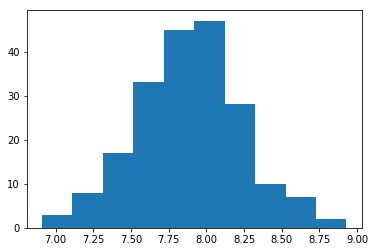

In [6]:
fig, ax = plt.subplots(1, 1)
ax.hist(pop)

In [7]:
pop.shape

(200,)

In [11]:
from scipy.stats import uniform,norm
dnorm=norm.logpdf
dunif=uniform.logpdf

In [19]:
def calc_posterior(t,d,y=pop):
    # Calculate joint posterior, given values  t
    
    # prior for delta: unif(0,1)
    logp = dunif(d, 0, 1) 
    
    # delta_new=delta_old+t, Priors on t: uniform between -1 and -1+2=1
    logp += dunif(t, -1, 2)
    
    dnew=d+t
    
    mu=7*dnew+(1-dnew)*10
    sigma=np.sqrt((dnew*0.05)**2+( (1-dnew)*0.5 )**2 )
    
    # Data likelihood
    logp += sum(dnorm(y, mu, sigma))
    
    return logp

In [20]:
#2. Implement a random walk M-H algorithm with proposal  δ′=δ(i)+ϵ  with  ϵ∼Unif(−1,1)

rnorm = np.random.normal
runif = np.random.uniform


def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values, trace is a 3 parameter list-use * to unravel
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts, start with [0,0,0]
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i) # every 1000, print sth
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            if j==2:
                # Ensure tau is positive (by exp)
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

In [35]:
n_iter = 10000
trace, acc = metropolis(n_iter, (1,0), 0.01)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [36]:
np.array(acc, float)/n_iter

array([ 0.4117,  0.4087])

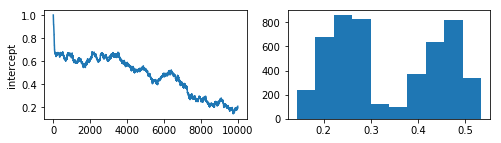

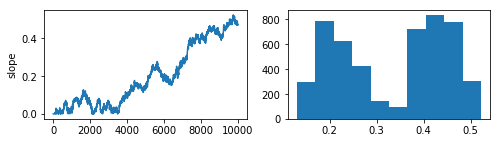

In [38]:
for param, samples in zip(['intercept', 'slope','precision'], trace.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

In [29]:
rnorm = np.random.normal
runif = np.random.uniform

def metropolis_tuned(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values, trace is a 3 parameter list-use * to unravel
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts, start with [0,0,0]
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i) # every 1000, print sth
    
        #p=trace[i].copy()
  
            
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            if not i%100:
                acc= accepted[i]
                if acc<10:
                    prop_sd[j]*=0.01
            
                elif acc>40:
                    prop_sd[j]*=100
                
            accepted[i]=0
            
            # Propose new value
            if j==2:
                # Ensure tau is positive (by exp)
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

In [28]:
n_iter

10000

In [30]:
trace_tuned,acc = metropolis_tuned(n_iter, (1,0))

Iteration 0


IndexError: list assignment index out of range

In [ ]:
#3 Reparameterize the problem letting  U=log[δ1−δ]U=log⁡[δ1−δ]  and  u′=u(i)+ϵu′=u(i)+ϵ . Implement a random walk chain in U-space.

In [119]:
np.empty((1,2))

array([[  3.00604243e-11,  -9.61386085e-14]])

# Question 4

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction. These data are given below.

In one possible random effects model we assume the true baseline mean (on a log-odds scale) $m_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$, and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

In this case, we want to make inferences about the population effect $m$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. 

This particular model uses a random effect for the population mean, and a fixed effect for the treatment effect. There are 3 other models you could fit to represent all possible combinations of fixed or random effects for these two parameters.

Build all 4 models to estimate the treatment effect in PyMC3 and 

1. use convergence diagnostics to check for convergence in each model 
2. use posterior predictive checks to compare the fit of the models
3. use DIC to compare the models as approximations of the true generating model

Which model would you select and why?

In [1]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

In [7]:
# Write answer here
#1
import pymc3 as pm

with pm.Model() meta:
    a=pm.Normal('a',0,sd=10)
    b=pm.Normal('b',0,sd=10)
    
    p=pm.invlogit(a+b*np.array(log_dose))
    
    y=pm.Binomial('y',n,p,observed=np.array(deaths))
    
    ld50=pm.Deterministic('ld50',-a/b